In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearnex import patch_sklearn
patch_sklearn()
from pylab import title, figure, xlabel, ylabel, xticks, bar, legend, axis, savefig
from fpdf import FPDF
import sdv
import sklearn
from sdv.constraints import Between
from sdv.tabular import GaussianCopula, CopulaGAN, CTGAN, TVAE
from sdv.metrics.tabular import KSTest
import time 
import tracemalloc

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import phik
from phik.report import plot_correlation_matrix
from phik import report

from datetime import datetime

sns.set(rc={'figure.figsize':(7,9)})

In [3]:
# Importing train_test_split from sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

# Importing r2_score module to calculate r square value
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.metrics import log_loss 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# Resampling technique
#import imblearn
from imblearn.over_sampling import SMOTE
# Installation syntax
#!pip install -U imbalanced-learn
from sklearn.preprocessing import StandardScaler

# Importing Regression libraries from sklearn
from sklearn.linear_model import ARDRegression, Ridge, Lasso, ElasticNet , HuberRegressor
from sklearn.linear_model import Lars, PassiveAggressiveRegressor, RANSACRegressor, SGDRegressor, TweedieRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.linear_model import BayesianRidge, LinearRegression

# Importing Boosting Regression algorithm
# If below library is not installed on your system then you can install using following syntax - !pip install lightgbm
from lightgbm import LGBMRegressor

# If below library is not installed on your system then you can install using following syntax - !pip install xgboost
from xgboost import XGBRegressor

# If below library is not installed on your system then you can install using following syntax - !pip install catboost
from catboost import CatBoostRegressor

# Importing library to save trained model
import pickle
import joblib

In [4]:
# Importing Classification libraries from sklearn
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

# Importing Boosting Classification algorithm
# If below library is not installed on your system then you can install using following syntax - !pip install lightgbm
from lightgbm import LGBMClassifier

# If below library is not installed on your system then you can install using following syntax - !pip install xgboost
from xgboost import XGBClassifier

# If below library is not installed on your system then you can install using following syntax - !pip install catboost
from catboost import CatBoostClassifier


In [5]:
#path_to_file = 'bank_train_data.csv'
#path_to_file = 'classsification_data.csv'
#path_to_file = 'commodity 2000-2022.csv'
#path_to_file = 'bank_train_data.csv'
#path_to_file = 'Acoustic_Extinguisher_Fire_Dataset.csv'
#path_to_file = 'house_price.csv'

In [6]:
def file_extension_read(path_to_file):
    file_extension = path_to_file[path_to_file.rfind('.')+1: ]
    
    if file_extension == 'xlsx':
        return pd.read_excel(path_to_file)
    elif file_extension == 'csv':
        return pd.read_csv(path_to_file)
    elif file_extension == 'json':
        return pd.read_json(path_to_file)
    elif file_extension == 'txt':
        delimiter = input("Enter the delimiter if required, otherwise just put it blank: ")
        return pd.read_table(path_to_file, delimiter=delimiter)

In [7]:
#df = file_extension_read(path_to_file)
#df.describe()

In [8]:
#df = file_extension_read(path_to_file)
#df = df.sample(n=5000, random_state=1)
#df.reset_index(drop= True, inplace = True)

In [9]:
#df.info()

In [10]:
def user_constraints(df):
    constraints = []
    constraints_dic = {}
    number_of_constraints = int(input("For how many variables do you want to apply the constraint: "))
    if (number_of_constraints > 0):
        for i in range(1, number_of_constraints+1):
            type_of_constraint = input(f"Constraint type for variable {i} [Between, Categorical]: ")
            if type_of_constraint == 'Between':
                print("------------------Between Constraint------------------")
                column = input("Enter the targeted column: ")
                low = int(input("Enter the lower value: "))
                high = int(input("Enter the higher value: "))
                constraints_dic[type_of_constraint+str(i)] = [column, low, high]
                df = df.loc[(df[column] > low) & (df[column] < high), :]
                constraints.append(Between(column = column, low=low, high=high, handling_strategy='transform'))
            elif type_of_constraint == 'Categorical':
                print("------------------Categorical Constraint------------------")
                column = input("Enter the targeted column: ")
                value_type = input("Is the value a string or a number - [String, Number]: ")
                if value_type == 'String':
                    value = input("Enter the targeted values using comma: ")
                    value_array = value.split(',')
                    constraints_dic[type_of_constraint+str(i)] = [value_array, column]
                elif value_type == 'Number':
                    value = input("Enter the targeted values using comma: ")
                    value_array = [int(i) for i in value.split(',')]
                    constraints_dic[type_of_constraint+str(i)] = [value_array, column]
                df = df.loc[df[column].isin(value_array), :]
        return constraints, df, constraints_dic
    else:
        return constraints, df, constraints_dic

In [11]:
def optimized_model(df_filtered, number_of_samples, constraints, models):
    for cols in df_filtered.columns:
        #if(df_filtered[cols].dtype == )
        #print(df_filtered[cols].dtype)
        #print(type(df_filtered[cols].dtype))
        
        if(df_filtered[cols].dtype == 'uint8'):
            df_filtered[cols] = df_filtered[cols].astype('int')
            
        #print(df_filtered[cols].dtype)
        #print(type(df_filtered[cols].dtype))
            
    
    closeness_list = []
    for i in models:
        model = i(constraints=constraints)
        model.fit(df_filtered)
        new_data = model.sample(number_of_samples)
        closeness = KSTest.compute(df_filtered, new_data)
        closeness_list.append(closeness) 
        continue
    max_element = max(closeness_list)
    return closeness_list.index(max_element), max_element, new_data, closeness_list

In [12]:
# ML Regression Pipeline
def mlRegPipeline(df_withTarget, targetColumn_name):
     # list of ml algorithm models
    algoPool = []
    algoName = []

    # Dataframe to store model name, model object, r_square value
    df_output_cols = ['model_name', 'model_object', 'r_square_value']
    df_output = pd.DataFrame(columns=df_output_cols)

    # separate the other attributes from the predicting attribute
    # Training data without target
    df_withTarget = pd.get_dummies(df_withTarget)

    X = df_withTarget.drop(targetColumn_name, axis=1)
    # Training data target variable
    y = df_withTarget[targetColumn_name]

    # splitting the training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123)

    randomForestRegressor_model = RandomForestRegressor()
    # Training the Models
    print("Algo 1")
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=100)],
                   'max_features': ['auto', 'sqrt'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num=10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False]}

    randomForestRegressor_model_best = RandomizedSearchCV(estimator=randomForestRegressor_model,
                                                          param_distributions=random_grid,
                                                          n_iter=25,
                                                          cv=3,
                                                          verbose=2,
                                                          random_state=42,
                                                          n_jobs=-1)
    algoPool.append(randomForestRegressor_model_best)
    algoName.append('RandomForestRegressor')

    # CatBoostRegressor Regression
    print("Algo 2")
    catboost_model = CatBoostRegressor()
    random_grid = {'depth': [6, 8, 10],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'iterations': [30, 50, 100]
                   }

    catboost_model_best = RandomizedSearchCV(estimator=catboost_model,
                                             param_distributions=random_grid,
                                             n_iter=25,
                                             scoring='r2',
                                             cv=3,
                                             verbose=2,
                                             random_state=42,
                                             n_jobs=-1)
    algoPool.append(catboost_model_best)
    algoName.append('CatBoostRegressor')
    
    
    # XGBRegressor Regression
    print("Algo 3")
    xgb_regressor_model = XGBRegressor(seed=20)

    random_grid = {'max_depth': [3, 5, 6, 10, 15, 20],
                   'learning_rate': [0.01, 0.1, 0.2, 0.3],
                   'subsample': np.arange(0.5, 1.0, 0.1),
                   'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                   'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                   'n_estimators': [100, 500, 1000]}

    xgb_regressor_model_best = RandomizedSearchCV(estimator=xgb_regressor_model,
                                                  param_distributions=random_grid,
                                                  scoring='r2',
                                                  n_iter=25,
                                                  verbose=1)
    algoPool.append(xgb_regressor_model_best)
    algoName.append('XGBRegressor')

    # LGBMRegressor Regression
    print("Algo 4")
    lightgbm_model = LGBMRegressor()

    random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=100)],
                   'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num=10)],
                   'min_split_gain': [2, 5, 10],
                   'min_child_samples': [int(x) for x in np.linspace(10, 110, num=10)]
                   }

    lightgbm_model_best = RandomizedSearchCV(estimator=lightgbm_model,
                                             param_distributions=random_grid,
                                             scoring='r2',
                                             n_iter=25,
                                             verbose=1)
    algoPool.append(lightgbm_model_best)
    algoName.append('LGBMRegressor')

    # ARD Regression
    print("Algo 5")
    ard_model = ARDRegression()

    random_grid = {'n_iter': [int(x) for x in np.linspace(start=300, stop=2000, num=100)],
                   'compute_score': [True, False],
                   'threshold_lambda': [int(x) for x in np.linspace(10000, 100000, num=10000)]}

    ard_model_best = RandomizedSearchCV(estimator=ard_model,
                                        param_distributions=random_grid,
                                        scoring='r2',
                                        n_iter=25,
                                        verbose=1)
    algoPool.append(ard_model_best)
    algoName.append('ARDRegression')

    # Ridge Regression
    print("Algo 6")
    ridge_model = Ridge()
    random_grid = {'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs']}

    ridge_model_best = RandomizedSearchCV(estimator=ridge_model,
                                          param_distributions=random_grid,
                                          scoring='r2',
                                          n_iter=25,
                                          verbose=1)
    algoPool.append(ridge_model_best)
    algoName.append('Ridge')

    # Lasso Regression
    print("Algo 7")
    lasso_model = Lasso()
    random_grid = {'alpha': [int(x) for x in np.linspace(start=1, stop=100, num=10)],
                   'normalize': [True, False],
                   'max_iter': [int(x) for x in np.linspace(start=1000, stop=10000, num=1000)],
                   'selection': ['cyclic', 'random']
                   }

    lasso_model_best = RandomizedSearchCV(estimator=lasso_model,
                                          param_distributions=random_grid,
                                          scoring='r2',
                                          n_iter=25,
                                          verbose=1)
    algoPool.append(lasso_model_best)
    algoName.append('Lasso')

    # ElasticNet Regression
    print("Algo 8")
    elasticNet_model = ElasticNet()

    random_grid = {'alpha': [int(x) for x in np.linspace(start=1, stop=100, num=10)],
                   'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   'normalize': [True, False],
                   'max_iter': [int(x) for x in np.linspace(start=1000, stop=10000, num=1000)],
                   'selection': ['cyclic', 'random']
                   }

    elasticNet_model_best = RandomizedSearchCV(estimator=elasticNet_model,
                                               param_distributions=random_grid,
                                               scoring='r2',
                                               n_iter=25,
                                               verbose=1)
    algoPool.append(elasticNet_model_best)
    algoName.append('ElasticNet')

    # Huber Regression
    print("Algo 9")
    huber_model = HuberRegressor()

    random_grid = {'epsilon': [int(x) for x in np.linspace(start=1, stop=50, num=5)],
                   'warm_start': [True, False],
                   'max_iter': [int(x) for x in np.linspace(start=1000, stop=10000, num=1000)]
                   }

    huber_model_best = RandomizedSearchCV(estimator=huber_model,
                                          param_distributions=random_grid,
                                          scoring='r2',
                                          n_iter=25,
                                          verbose=1)

    algoPool.append(huber_model_best)
    algoName.append('HuberRegressor')

    # Lars Regression
    print("Algo 10")
    lars_model = Lars()

    random_grid = {'n_nonzero_coefs': [int(x) for x in np.linspace(start=500, stop=50000, num=5000)]
                   }

    lars_model_best = RandomizedSearchCV(estimator=lars_model,
                                         param_distributions=random_grid,
                                         scoring='r2',
                                         n_iter=25,
                                         verbose=1)

    algoPool.append(lars_model_best)
    algoName.append('Lars')

    # PassiveAggressiveRegressor Regression
    print("Algo 11")
    passiveAggressiveRegressor_model = PassiveAggressiveRegressor()

    random_grid = {'epsilon': [int(x) for x in np.linspace(start=1, stop=50, num=5)],
                   'early_stopping': [True, False],
                   'average': [True, False],
                   'warm_start': [True, False],
                   'validation_fraction': [0.1, 0.2, 0.3, 0.4, 0.5],
                   'max_iter': [int(x) for x in np.linspace(start=1000, stop=10000, num=1000)]
                   }

    passiveAggressiveRegressor_model_best = RandomizedSearchCV(estimator=passiveAggressiveRegressor_model,
                                                               param_distributions=random_grid,
                                                               scoring='r2',
                                                               n_iter=25,
                                                               verbose=1)

    algoPool.append(passiveAggressiveRegressor_model_best)
    algoName.append('PassiveAggressiveRegressor')

    # RANSACRegressor Regression
    print("Algo 12")
    ransac_Regressor_model = RANSACRegressor()
    random_grid = {'max_trials': [int(x) for x in np.linspace(start=100, stop=10000, num=100)],
                   'loss': ['absolute_error', 'squared_error'],
                   'stop_probability': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
                   'max_trials': [int(x) for x in np.linspace(start=100, stop=10000, num=1000)]
                   }

    ransac_Regressor_model_best = RandomizedSearchCV(estimator=ransac_Regressor_model,
                                                     param_distributions=random_grid,
                                                     scoring='r2',
                                                     n_iter=25,
                                                     verbose=1)
    algoPool.append(ransac_Regressor_model_best)
    algoName.append('RANSACRegressor')

    # KernelRidge Regression
    print("Algo 13")
    kernelRidge_model = KernelRidge()

    random_grid = {'alpha': [int(x) for x in np.linspace(start=1, stop=100, num=5)],
                   'degree': [1, 2, 3, 4, 5]
                   }

    kernelRidge_model_best = RandomizedSearchCV(estimator=kernelRidge_model,
                                                param_distributions=random_grid,
                                                scoring='r2',
                                                n_iter=25,
                                                verbose=1)

    algoPool.append(kernelRidge_model_best)
    algoName.append('KernelRidge')

    # BayesianRidge Regression
    print("Algo 14")
    bayesianRidge_model = BayesianRidge()
    random_grid = {'lambda_init': [int(x) for x in np.linspace(start=1, stop=100, num=5)],
                   'compute_score': [True, False],
                   'normalize': [True, False]
                   }

    bayesianRidge_model_best = RandomizedSearchCV(estimator=bayesianRidge_model,
                                                  param_distributions=random_grid,
                                                  scoring='r2',
                                                  n_iter=25,
                                                  verbose=1)
    algoPool.append(bayesianRidge_model_best)
    algoName.append('BayesianRidge')

    # TweedieRegressor Regression
    print("Algo 15")
    tweedieRegressor_model = TweedieRegressor()

    random_grid = {
        'alpha': [int(x) for x in np.linspace(start=1, stop=100, num=10)],
        'link': ['auto', 'identity', 'log'],
        'max_iter': [int(x) for x in np.linspace(start=100, stop=1000, num=100)],
        'warm_start': [True, False]
    }

    tweedieRegressor_model_best = RandomizedSearchCV(estimator=tweedieRegressor_model,
                                                     param_distributions=random_grid,
                                                     scoring='r2',
                                                     n_iter=25,
                                                     verbose=1)

    algoPool.append(tweedieRegressor_model_best)
    algoName.append('TweedieRegressor')

    # BaggingRegressor Regression
    print("Algo 17")
    baggingRegressor_model = BaggingRegressor()

    random_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=1000, num=100)],
        'bootstrap': [True, False],
        'oob_score': [True, False],
        'warm_start': [True, False],
        'bootstrap_features': [True, False]
    }

    baggingRegressor_model_best = RandomizedSearchCV(estimator=baggingRegressor_model,
                                                     param_distributions=random_grid,
                                                     scoring='r2',
                                                     n_iter=25,
                                                     verbose=1)

    algoPool.append(baggingRegressor_model_best)
    algoName.append('BaggingRegressor')

    # SGDRegressor Regression
    print("Algo 18")
    sgd_Regressor_model = SGDRegressor()

    random_grid = {
        'loss': ['squared_error', 'huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'max_iter': [int(x) for x in np.linspace(start=1000, stop=10000, num=1000)],
        'shuffle': [True, False],
        'learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
        'validation_fraction': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'early_stopping': [True, False],
        'warm_start': [True, False],
        'average': [True, False]
    }

    sgd_Regressor_model_best = RandomizedSearchCV(estimator=sgd_Regressor_model,
                                                  param_distributions=random_grid,
                                                  scoring='r2',
                                                  n_iter=25,
                                                  verbose=1)

    algoPool.append(sgd_Regressor_model_best)
    algoName.append('SGDRegressor')
    
    
    print("algoPool = ", algoPool)
    # Training each model using X_train and y_train
    algoPool_trained_model = []
    time_list = []
    all_model_start = time.time()
    for number, model in enumerate(algoPool):
        print("Model = ", number)
        print("Model name = ", model)
        # print("Model type = ", type(model))

        start = time.time()

        # print("Model type = ", str(model))
        # print("Model type = ", type(str(model)))

        if (str(model) == 'LinearRegression()'):
            algoPool_trained_model.append(model.fit(X_train, y_train, sample_weight=None))
        else:
            algoPool_trained_model.append(model.fit(X_train, y_train))

        end = time.time()
        print("time_taken ", number, end - start)
        time_list.append(end - start)

    all_model_end = time.time()
    print("time_list = ", time_list)
    all_model_time = all_model_end - all_model_start
    print("all_model_time = ", all_model_time)

    # algoPool_trained_model = [model.fit(X_train, y_train) for model in algoPool ]

    # Storing Model name in dataframe
    df_output['Algo_name'] = algoName
    df_output['model_name'] = [type(model).__name__ for model in algoPool_trained_model]
    # Storing Model object in dataframe
    df_output['model_object'] = algoPool_trained_model
    # Storing r square value of Model in dataframe
    df_output['r_square_value'] = [r2_score(y_test, model.predict(X_test)) for model in algoPool_trained_model]

    # Sorting output dataframe by r_square value - 1st Output
    df_output.sort_values(by=['r_square_value'], ascending=False, inplace=True, ignore_index=True)

    # Save the model as a pickle in a file - 2nd output
    joblib.dump(df_output.loc[0, 'model_object'], 'best_regression_model.pkl')

    # Load the model from the file
    best_model_from_joblib = joblib.load('best_regression_model.pkl')
    best_model_from_joblib = best_model_from_joblib.fit(X_train, y_train)

    print("Best Parameter - ", best_model_from_joblib.best_params_)
    # Use the loaded model to make predictions
    # df_withoutTarget[targetColumn_name] = best_model_from_joblib.predict(df_withoutTarget_afterProcess)

    # To save output file in csv - 3rd output
    # df_withoutTarget.to_csv('output_test_data.csv', index=False)

    return df_output, best_model_from_joblib, best_model_from_joblib.best_params_, df_output.loc[0, 'Algo_name']


In [13]:
# ML classification Pipeline
def mlClassificationPipeline(df_withTarget, targetColumn_name):
    # Algo pool list
    algoPool = []
    algoName = []

    # Dataframe to store model name, model object, r_square value
    df_output_cols = ['model_name', 'model_object', 'r_square_value']
    df_output = pd.DataFrame(columns=df_output_cols)

    #gaussianNB_best = GaussianNB()
    #algoPool.append(gaussianNB_best)
    #algoName.append('GaussianNB')

    logisticRegression = LogisticRegression()
    random_grid = {'penalty': ['l1', 'l2', 'elasticnet', None],
                   'max_iter': [int(x) for x in np.linspace(start=100, stop=1000, num=100)],
                   'warm_start': [True, False],
                   'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
                   'class_weight': ['balanced', None],
                   'dual': [True, False]}

    logisticRegression_best = RandomizedSearchCV(estimator=logisticRegression,
                                                 param_distributions=random_grid,
                                                 n_iter=25,
                                                 cv=3,
                                                 verbose=2,
                                                 random_state=42,
                                                 scoring='roc_auc',
                                                 n_jobs=-1,
                                                 refit=True)
    algoPool.append(logisticRegression_best)
    algoName.append('LogisticRegression')

    kNeighborsClassifier = KNeighborsClassifier()
    random_grid = {
        'n_neighbors': [int(x) for x in np.linspace(start=5, stop=55, num=5)],
        'leaf_size': [int(x) for x in np.linspace(start=30, stop=120, num=30)],
        'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis'],
        'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
        'weights': ['uniform', 'distance']
    }

    kNeighborsClassifier_best = RandomizedSearchCV(estimator=kNeighborsClassifier,
                                                   param_distributions=random_grid,
                                                   n_iter=25,
                                                   cv=3,
                                                   verbose=2,
                                                   random_state=42,
                                                   scoring='roc_auc',
                                                   n_jobs=-1,
                                                   refit=True)
    algoPool.append(kNeighborsClassifier_best)
    algoName.append('KNeighborsClassifier')

    decisionTreeClassifier = DecisionTreeClassifier()
    random_grid = {'criterion': ['gini', 'entropy'],
                   'splitter': ['best', 'random'],
                   'max_depth': [int(x) for x in np.linspace(start=5, stop=25, num=5)],
                   'min_samples_leaf': [int(x) for x in np.linspace(start=1, stop=15, num=3)],
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'class_weight': ['balanced']
                   }

    decisionTreeClassifier_best = RandomizedSearchCV(estimator=decisionTreeClassifier,
                                                     param_distributions=random_grid,
                                                     n_iter=25,
                                                     cv=3,
                                                     verbose=2,
                                                     random_state=42,
                                                     scoring='roc_auc',
                                                     n_jobs=-1,
                                                     refit=True)
    algoPool.append(decisionTreeClassifier_best)
    algoName.append('DecisionTreeClassifier')
    
    
    baggingClassifier = BaggingClassifier()
    random_grid = {
        'n_estimators': [int(x) for x in np.linspace(start=10, stop=1000, num=100)],
        'bootstrap': [True, False],
        'bootstrap_features': [True, False],
        'oob_score': [True, False],
        'warm_start': [True, False]
    }

    baggingClassifier_best = RandomizedSearchCV(estimator=baggingClassifier,
                                                param_distributions=random_grid,
                                                n_iter=25,
                                                cv=3,
                                                verbose=2,
                                                random_state=42,
                                                scoring='roc_auc',
                                                n_jobs=-1,
                                                refit=True)
    algoPool.append(baggingClassifier_best)
    algoName.append('BaggingClassifier')

    gradientBoostingClassifier = GradientBoostingClassifier()
    random_grid = {
        'loss': ['deviance', 'exponential'],
        'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
        'validation_fraction': [0.1, 0.2, 0.3, 0.4],
        'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=100)],
        'max_features': ['auto', 'sqrt', 'log2'],
        'warm_start': [True, False]
    }

    gradientBoostingClassifier_best = RandomizedSearchCV(estimator=gradientBoostingClassifier,
                                                         param_distributions=random_grid,
                                                         n_iter=25,
                                                         cv=3,
                                                         verbose=2,
                                                         random_state=42,
                                                         scoring='roc_auc',
                                                         n_jobs=-1,
                                                         refit=True)
    algoPool.append(gradientBoostingClassifier_best)
    algoName.append('GradientBoostingClassifier')

    randomForestClassifier = RandomForestClassifier()
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start=200, stop=2000, num=100)],
                   'criterion': ['gini', 'entropy'],
                   'max_features': ['auto', 'sqrt', 'log2'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num=10)],
                   'min_samples_split': [2, 5, 10],
                   'min_samples_leaf': [1, 2, 4],
                   'bootstrap': [True, False],
                   'warm_start': [True, False],
                   'class_weight': ['balanced', 'balanced_subsample']
                   }

    randomForestClassifier_best = RandomizedSearchCV(estimator=randomForestClassifier,
                                                     param_distributions=random_grid,
                                                     n_iter=25,
                                                     cv=3,
                                                     verbose=2,
                                                     random_state=42,
                                                     scoring='roc_auc',
                                                     n_jobs=-1,
                                                     refit=True)
    algoPool.append(randomForestClassifier_best)
    algoName.append('RandomForestClassifier')

    adaBoostClassifier = AdaBoostClassifier()
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start=50, stop=1000, num=50)],
                   'algorithm': ['SAMME', 'SAMME.R'],
                   'learning_rate': [int(x) for x in np.linspace(1, 20, num=3)]

                   }

    adaBoostClassifier_best = RandomizedSearchCV(estimator=adaBoostClassifier,
                                                 param_distributions=random_grid,
                                                 n_iter=25,
                                                 cv=3,
                                                 verbose=2,
                                                 random_state=42,
                                                 scoring='roc_auc',
                                                 n_jobs=-1,
                                                 refit=True)
    algoPool.append(adaBoostClassifier_best)
    algoName.append('AdaBoostClassifier')

    mLPClassifier = MLPClassifier()
    random_grid = {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [int(x) for x in np.linspace(200, 1000, num=100)],
        'shuffle': [True, False],
        'warm_start': [True, False],
        'nesterovs_momentum': [True, False],
        'early_stopping': [True, False]

    }

    mLPClassifier_best = RandomizedSearchCV(estimator=mLPClassifier,
                                            param_distributions=random_grid,
                                            n_iter=25,
                                            cv=3,
                                            verbose=2,
                                            random_state=42,
                                            scoring='roc_auc',
                                            n_jobs=-1,
                                            refit=True)
    algoPool.append(mLPClassifier_best)
    algoName.append('MLPClassifier')

    xGBClassifier = XGBClassifier()
    random_grid = {'max_depth': [3, 5, 6, 10, 15, 20],
                   'learning_rate': [0.01, 0.1, 0.2, 0.3],
                   'subsample': np.arange(0.5, 1.0, 0.1),
                   'colsample_bytree': np.arange(0.4, 1.0, 0.1),
                   'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
                   'n_estimators': [100, 500, 1000]}

    xGBClassifier_best = RandomizedSearchCV(estimator=xGBClassifier,
                                            param_distributions=random_grid,
                                            n_iter=25,
                                            cv=3,
                                            verbose=2,
                                            random_state=42,
                                            scoring='roc_auc',
                                            n_jobs=-1,
                                            refit=True)
    algoPool.append(xGBClassifier_best)
    algoName.append('XGBClassifier')

    lGBMClassifier = LGBMClassifier()
    random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=100)],
                   'boosting_type': ['gbdt', 'dart', 'goss', 'rf'],
                   'max_depth': [int(x) for x in np.linspace(10, 110, num=10)],
                   'min_split_gain': [2, 5, 10],
                   'min_child_samples': [int(x) for x in np.linspace(10, 110, num=10)]
                   }

    lGBMClassifier_best = RandomizedSearchCV(estimator=lGBMClassifier,
                                             param_distributions=random_grid,
                                             n_iter=25,
                                             cv=3,
                                             verbose=2,
                                             random_state=42,
                                             scoring='roc_auc',
                                             n_jobs=-1,
                                             refit=True)
    algoPool.append(lGBMClassifier_best)
    algoName.append('LGBMClassifier')

    catBoostClassifier = CatBoostClassifier()
    random_grid = {'depth': [6, 8, 10],
                   'learning_rate': [0.01, 0.05, 0.1],
                   'iterations': [30, 50, 100]
                   }

    catBoostClassifier_best = RandomizedSearchCV(estimator=catBoostClassifier,
                                                 param_distributions=random_grid,
                                                 n_iter=25,
                                                 cv=3,
                                                 verbose=2,
                                                 random_state=42,
                                                 scoring='roc_auc',
                                                 n_jobs=-1,
                                                 refit=True)
    algoPool.append(catBoostClassifier_best)
    algoName.append('CatBoostClassifier')
    

    df_withTarget = pd.get_dummies(df_withTarget)

    X = df_withTarget.drop(targetColumn_name, axis=1)
    # Training data target variable
    y = df_withTarget[targetColumn_name]

    # splitting the training data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test = sc.transform(X_test)

    oversample = SMOTE()
    X_train, y_train = oversample.fit_resample(X_train, y_train)

    # Training each model using X_train and y_train

    time_list = []
    algoPool_trained_model = []
    all_model_start = time.time()
    for number, model in enumerate(algoPool):
        print("Model = ", number)
        print("Model name = ", model)
        # print("Model type = ", type(model))

        start = time.time()

        # print("Model type = ", str(model))
        # print("Model type = ", type(str(model)))

        algoPool_trained_model.append(model.fit(X_train, y_train))

        end = time.time()
        print("time_taken ", number, end - start)
        time_list.append(end - start)
    all_model_end = time.time()
    print("time_list = ", time_list)
    all_model_time = all_model_end - all_model_start
    print("all_model_time = ", all_model_time)

    # algoPool_trained_model = [model.fit(X_train, y_train) for model in algoPool ]

    df_output = pd.DataFrame()
    # Storing Model name in dataframe
    df_output['Algo_name'] = algoName
    df_output['model_name'] = [type(model).__name__ for model in algoPool_trained_model]
    # Storing Model object in dataframe
    df_output['model_object'] = algoPool_trained_model
    # Storing model accuracy value of Model in dataframe
    df_output['accuracy'] = [accuracy_score(y_test, model.predict(X_test)) for model in algoPool_trained_model]

    # Storing model f1_score value of Model in dataframe
    df_output['f1_score'] = [f1_score(y_test, model.predict(X_test)) for model in algoPool_trained_model]

    # Storing model log_loss value of Model in dataframe
    df_output['log_loss_score'] = [log_loss(y_test, model.predict(X_test), eps=1e-15) for model in
                                   algoPool_trained_model]

    df_output['roc_auc_score'] = [roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]) for model in
                                  algoPool_trained_model]

    # Sorting output dataframe by roc_auc_score value - 1st Output
    df_output.sort_values(by=['accuracy'], ascending=False, inplace=True, ignore_index=True)

    # Save the model as a pickle in a file - 2nd output
    joblib.dump(df_output.loc[0, 'model_object'], 'best_classification_model.pkl')

    # Load the model from the file
    best_model_from_joblib = joblib.load('best_classification_model.pkl')
    best_model_from_joblib = best_model_from_joblib.fit(X_train, y_train)

    print("Best Parameter - ", best_model_from_joblib.best_params_)

    # To save output file in csv - 3rd output
    # df_output.to_csv('algorithm_output.csv', index=False)

    return df_output, best_model_from_joblib, best_model_from_joblib.best_params_, df_output.loc[0, 'Algo_name']


In [14]:
def regression_simulation(df, target_variable, number_of_samples, reg, best_r2, threshold_value, min_value_deviation, max_value_deviation):
    #df = pd.get_dummies(df)
    # X = df.iloc[:, 0:len(df.columns.tolist())-1].values
    # y = df.iloc[:, -1].values

    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    #     output_df, reg = mlRegPipeline(df, target_variable)
    X = pd.get_dummies(X)
    y_pred = reg.predict(X)
    print("R2 Score: ", best_r2)

    sample_df = df.copy()
    sample_df.drop(columns=target_variable, inplace=True)
    df_predicted = pd.DataFrame(X, columns=sample_df.columns.tolist())
    df_predicted[target_variable] = y_pred

    threshold_constraint = (abs(min_value_deviation) + abs(max_value_deviation))/ 2
    threshold_value = int(threshold_value)
    min_value_deviation = int(min_value_deviation)
    max_value_deviation = int(max_value_deviation)
    min_value = threshold_value + (min_value_deviation / 100) * threshold_value
    max_value = threshold_value + (max_value_deviation / 100) * threshold_value
    df_predicted_filtered = df_predicted.loc[(df_predicted[target_variable] >= min_value) & (df_predicted[target_variable] <= max_value), :].copy()

    #     reg = train_test_reg(df_predicted_filtered, reg)

    df_test = df_predicted_filtered.copy()
    df_test.drop(columns=target_variable, inplace=True)

    models = [GaussianCopula, CopulaGAN, CTGAN, TVAE]
    models_string = ['GaussianCopula', 'CopulaGAN', 'CTGAN', 'TVAE']
    
    user_time_start = time.time()
    constraints, df_filtered, constraints_dic = user_constraints(df_test)
    user_time_end = time.time()
    user_time = user_time_end - user_time_start
    

    if len(df_filtered) <= 10:
        model = GaussianCopula(constraints=constraints)
        model.fit(df_filtered)
        df_filtered = model.sample(20)

    index, max_element, new_data, models_value_list = optimized_model(df_filtered,
                                                                                         number_of_samples,
                                                                                         constraints, models)
    print("\nModel Used: {}".format(models_string[index]))
    max_element = max_element * 100
    print("Closeness to the real value dataset: {:.2f}%\n".format(max_element))

    X_temp = pd.get_dummies(new_data)
    y_pred_close = reg.predict(X_temp)
    #     len(y_pred_close)
    y_pred_close_filtered = y_pred_close[(y_pred_close >= min_value) & (y_pred_close <= max_value)]
    #     print(len(y_pred_close_filtered))

    deviation_histo = []
    for i in y_pred_close_filtered:
        deviation = (i - threshold_value) / threshold_value
        deviation_histo.append(deviation)
    deviation_histo_original = []
    for i in y_pred_close:
        deviation = (i - threshold_value) / threshold_value
        deviation_histo_original.append(deviation)
    #     print(len(deviation_histo))
    plt.clf()
    sns.histplot(data=deviation_histo, kde=True).set(title="Positive and negative deviation from the estimation value - Filtered Data")
    plt.clf()
    sns.histplot(data=deviation_histo_original, kde=True).set(title="Positive and negative deviation from the estimation value - Full Samples")
    plt.clf()
    sns.histplot(data=y_pred_close, kde=True).set(title="Distribution of the synthetic dataset")

    true_percentage = (len(deviation_histo) / number_of_samples)
    true_percentage *= true_percentage
    risk_percentage = (1 - true_percentage) * 100
    print("Estimated Risk calculated by the simulation program: {:.2f}%".format(risk_percentage))
    return new_data, threshold_value, threshold_constraint, min_value, max_value, max_element, number_of_samples, models_string[index], deviation_histo, deviation_histo_original, y_pred_close, y_pred_close_filtered, true_percentage, constraints_dic, user_time

In [15]:
def classification_simulation(df, target_variable, number_of_samples, clf, best_accuracy, threshold_value_call, less_great):
    #df = pd.get_dummies(df)

    print("clf = ", clf)
    print("type(clf) = ", type(clf))

    for cols in df.columns:
        # if(df_filtered[cols].dtype == )
        print(df[cols].dtype)
        print(type(df[cols].dtype))

        if (df[cols].dtype == 'uint8'):
            df[cols] = df[cols].astype('int')

        print(df[cols].dtype)
        print(type(df[cols].dtype))

    X = df.drop(target_variable, axis=1)
    y = df[target_variable]

    X_get_dummies = pd.get_dummies(X)
    sc = StandardScaler()
    X_sc = sc.fit_transform(X_get_dummies)

    y_pred = clf.predict_proba(X_sc)[:, 1]
    y_pred = list(y_pred)
    y_pred = [i * 100 for i in y_pred]

    sample_df = df.copy()
    sample_df.drop(columns=target_variable, inplace=True)
    df_predicted = pd.DataFrame(X, columns=sample_df.columns.tolist())
    df_predicted[target_variable] = y_pred

    print("1 df_predicted[target_variable]", df_predicted[target_variable])
    threshold_value = threshold_value_call
    #threshold_constraint = int(input("Agreed deviation percentage: "))
    #min_value = threshold_value - (threshold_constraint / 100) * threshold_value
    #max_value = threshold_value + (threshold_constraint / 100) * threshold_value
    #print("min_value = ", min_value)
    #print("max_value = ", max_value)

    if(less_great == 'Greater than'):
        df_predicted_filtered = df_predicted.loc[(df_predicted[target_variable] >= threshold_value), :].copy()
    elif(less_great == 'Less than'):
        df_predicted_filtered = df_predicted.loc[(df_predicted[target_variable] <= threshold_value),:].copy()

    df_predicted_filtered[target_variable] = [1 if i > 50 else 0 for i in df_predicted_filtered[target_variable]]
    print("2 df_predicted_filtered[target_variable]", df_predicted_filtered[target_variable])

    #clf = train_test_clf(df_predicted_filtered, clf)

    df_test = df_predicted_filtered.copy()
    df_test.drop(columns=target_variable, inplace=True)

    models = [GaussianCopula, CopulaGAN, CTGAN, TVAE]
    models_string = ['GaussianCopula', 'CopulaGAN', 'CTGAN', 'TVAE']
  
    user_time_start = time.time()
    constraints, df_filtered, constraints_dic = user_constraints(df_test)
    user_time_end = time.time()
    user_time = user_time_end - user_time_start
    

    if len(df_filtered) <= 10:
        model = GaussianCopula(constraints=constraints)
        model.fit(df_filtered)
        df_filtered = model.sample(20)

    index, max_element, new_data, models_value_list = optimized_model(df_filtered, number_of_samples,
                                                                                         constraints, models)
    print("\nModel Used: {}".format(models_string[index]))
    max_element = max_element * 100
    print("Closeness to the real value dataset: {:.2f}%\n".format(max_element))

    print("3 clf = ", clf)
    print("3 type(clf) = ", type(clf))

    #st.write('new_data.values: ', type(new_data))

    X_after = pd.get_dummies(new_data)
    #st.write('X.columns: ', X.columns)
    #st.write('X_get_dummies.columns: ', X_get_dummies.columns)
    #st.write('X_after.columns: ', X_after.columns)
    X_after = sc.transform(X_after)
    #X_after = pd.get_dummies(X_after)
    y_pred_close = clf.predict_proba(X_after)[:, 1]

    y_pred_close = [i * 100 for i in y_pred_close]

    if (less_great == 'Greater than'):
        y_pred_close_filtered = [i for i in y_pred_close if i >= threshold_value]
        #y_pred_close_filtered = y_pred_close[for i in y_pred_close >= threshold_value]
    elif (less_great == 'Less than'):
        y_pred_close_filtered = [i for i in y_pred_close if i <= threshold_value]


    #     len(y_pred_close)
    #y_pred_close_filtered = y_pred_close[(y_pred_close >= min_value) & (y_pred_close <= max_value)]
    #     print(len(y_pred_close_filtered))

    deviation_histo = []
    for i in y_pred_close_filtered:
        deviation = (i - threshold_value) / threshold_value
        deviation_histo.append(deviation)
    deviation_histo_original = []
    for i in y_pred_close:
        deviation = (i - threshold_value) / threshold_value
        deviation_histo_original.append(deviation)
    #     print(len(deviation_histo))
    plt.clf()
    sns.histplot(data=deviation_histo, kde=True).set(title="Positive and negative deviation from the estimation value")

    true_percentage = (len(deviation_histo) / number_of_samples)
    risk_percentage = (1 - true_percentage) * 100
    print("Estimated Risk calculated by the simulation program: {:.2f}%".format(risk_percentage))
    return new_data, threshold_value, max_element, number_of_samples, models_string[index], deviation_histo, deviation_histo_original, y_pred_close, y_pred_close_filtered, true_percentage, constraints_dic, user_time

In [16]:
#df.describe()

In [17]:
def start_process(df, target, sample_size, threshold_value, min_value, max_value, model_present, model_obj, less_great, project_name):
    time_list = []
    memory_usage = []

    begin = time.time()
    tracemalloc.start()

    if (df[target].nunique() > 2):
        if(model_present == 'no'):
            output_df, reg, best_parameter, best_model_name = mlRegPipeline(df, target)
            #best_r2 = output_df['r_square_value'][0]
            best_r2 = 'NA'
        else:
            reg = model_obj
            #best_r2 = r2_score(df[target], model_obj.predict(df.drop(target, axis=1)))
            best_r2 = 'NA'
        generated_data, threshold_value, threshold_constraint, min_value, max_value, closeness, number_of_samples, model_value, deviation_histo, deviation_histo_original, y_pred_close, y_pred_close_filtered, true_percentage, constraints_dic, user_time = regression_simulation(df, target, sample_size, reg, best_r2, threshold_value, min_value, max_value)
        type_of_problem = 'regression'
        #generated_data.to_csv('generated_data.csv', index=False)

        #st.write('before generated_data.columns: ', generated_data.columns)
        #generated_data = undummify(generated_data)
        #st.write('after generated_data.columns: ', generated_data.columns)
    else:
        if (model_present == 'no'):
            output_df, clf, best_parameter, best_model_name = mlClassificationPipeline(df, target)
            #best_r2 = output_df['r_square_value'][0]
        else:
            clf = model_obj
            output_df = 'temp'
            #best_r2 = r2_score(df[target], model_obj.predict(df.drop(target, axis=1)))
        # classification_simulation(df, target, 50000, reg)

        generated_data, threshold_value, closeness, number_of_samples, model_value, deviation_histo, deviation_histo_original, y_pred_close, y_pred_close_filtered, true_percentage, constraints_dic, user_time = classification_simulation(
               df, target, sample_size, clf, output_df, threshold_value, less_great)
        type_of_problem = 'classification'
        #st.write('before generated_data.columns: ', generated_data.columns)
        #generated_data = undummify(generated_data)
        #st.write('after generated_data.columns: ', generated_data.columns)

    if(type_of_problem == 'classification'):
        threshold_constraint = 0
        min_value = 0
        max_value = 0


    memory_usage_process = tracemalloc.get_traced_memory()
    print("RAM Usage [Bytes]: {}".format(memory_usage_process[1]))
    memory_usage.append(memory_usage_process)

    tracemalloc.stop()
    end = time.time()
    total_time = end - begin - user_time
    time_list.append(total_time)
    #total_time += 403.0025112628937
    print("Total time taken [Seconds]: {}".format(total_time))

    deviation_histo_original_df = pd.DataFrame()
    deviation_histo_original_df['Deviation'] = deviation_histo_original
    deviation_histo_original_df['hue'] = ['Positive Deviation' if x >= 0 else 'Negative Deviation' for x in deviation_histo_original ]
    # plt.figure(figsize=(12,9))
    plt.clf()
    ax = sns.histplot(data=deviation_histo_original_df, x='Deviation', hue= 'hue', kde=True).set(
          title="Positive and Negative Deviation from the estimation value ");
    positive_samples = [x for x in deviation_histo_original if x >= 0]
    negative_samples = [x for x in deviation_histo_original if x < 0]
    positive_deviation = (len(positive_samples) / len(deviation_histo_original)) * 100
    negative_deviation = (len(negative_samples) / len(deviation_histo_original)) * 100
    plt.savefig("temp_image/Deviation.png")

    def plot_hist_regression():
        plt.clf()

        df_histo = pd.DataFrame({"Predicted": y_pred_close})
        df_histo.reset_index(drop=True, inplace=True)


        df_histo['Category'] = ['In-Range' if((i >= min_value) and (i <= max_value)) else 'Outside-Range' for i in y_pred_close]
        df_histo.reset_index(drop=True, inplace=True)
        #df_histo.to_csv('df_histo.csv', index= False)
        #df_histo['Category'] = filtered_list
        #st.write("min_value: ", min_value)
        #st.write("max_value: ", max_value)
        print("df_histo value count", df_histo['Category'].value_counts())
        #st.write("df_histo value count", df_histo['Category'].value_counts())
        #plt.figure(figsize=(7, 7))
        #ax = sns.histplot(data=df_histo, x='Predicted', hue='Category', bins=50)
        ax = sns.histplot(data=df_histo, x='Predicted', hue='Category')
        fig = ax.get_figure()
        fig.savefig("temp_image/Distribution.png")
        (n, bins, patches) = plt.hist(y_pred_close, bins=50)
        n = n.tolist()
        bins = bins.tolist()
        lower_range = bins[n.index(max(n))]
        upper_range = lower_range + ax.patches[1].xy[0] - ax.patches[0].xy[0]
        highest_count = max(n)
        ax.set_title("Distribution of the Synthetic Dataset from the Predictive Estimation")
        ax.set(xlabel='Predicted Values', ylabel='Count')

        return lower_range, upper_range, highest_count

    def plot_hist_classification():
        plt.clf()
        df_histo = pd.DataFrame({"Predicted": y_pred_close})
        filtered_list = []
        filtered_list.clear()
        for num_data in y_pred_close:
            if(less_great == 'Greater than'):
                if num_data >= threshold_value:
                    filtered_list.append('In-Range')
                else:
                    filtered_list.append('Outside-Range')
            else:
                if num_data <= threshold_value:
                    filtered_list.append('In-Range')
                else:
                    filtered_list.append('Outside-Range')

        df_histo['Category'] = filtered_list
        print(df_histo['Category'].value_counts())
        #palette = {"In-Range": "C0", "Outside-Range": "C1"}
        plt.figure(figsize=(7, 7))
        ax = sns.histplot(data=df_histo, x='Predicted', hue='Category', bins=50)
        ax.set_title("Distribution of the Synthetic Dataset from the Predictive Estimation")
        ax.set(xlabel='Predicted Probability (in percentage)', ylabel='Count');
        fig = ax.get_figure()
        fig.savefig("temp_image/Distribution.png")

        (n, bins, patches) = plt.hist(y_pred_close, bins=50)
        n = n.tolist()
        bins = bins.tolist()
        lower_range = bins[n.index(max(n))]
        upper_range = lower_range + ax.patches[1].xy[0] - ax.patches[0].xy[0]
        highest_count = max(n)

        return lower_range, upper_range, highest_count

    if (type_of_problem == 'regression'):
        lower_range, upper_range, highest_count = plot_hist_regression()
    elif(type_of_problem == 'classification'):
        lower_range, upper_range, highest_count = plot_hist_classification()

    plt.clf()
    #generated_data.dropna(axis=1, how= 'all', inplace = True)
    #generated_data = generated_data.loc[:, (generated_data != 0).any(axis=0)]

    phik_matrix = generated_data.phik_matrix()
    #phik_matrix = generated_data.corr()
    plt.figure(figsize=(13, 13))
    heatmap_plot = sns.heatmap(phik_matrix, cmap='Blues', annot=True, linewidth=0.5, linecolor='black')
    heatmap = heatmap_plot.get_figure()
    heatmap.savefig("temp_image/Heatmap.png")

    # Current date and time calculation
    now = datetime.now()
    dt_string = now.strftime("%d/%m/%Y %H:%M:%S")

    def set_bold(txt, h, pdf):
        pdf.set_font('arial', 'B', 12)
        pdf.write(h=h, txt=txt)
        pdf.set_font('arial', '', 12)

    def pdf_generate_regression(close_data):
        pdf = FPDF('P', 'mm', 'A4')
        pdf.add_page()
        pdf.set_auto_page_break(True, margin=10)
        pdf.accept_page_break()
        pdf.set_font('arial', 'B', 15)
        pdf.set_xy(20, 10)
        pdf.cell(w=170, h=10, txt="PREDICTIVE ESTIMATION RISK REPORT", border=0, ln=1, align='C', fill=False, link='')
        pdf.cell(w=170, h=10, txt="Project: "+project_name + " - Date: " + dt_string, border=0, ln=1, align='C', fill=False, link='')
        pdf.set_font('arial', '', 12)
        pdf.set_xy(10, 40)

        pdf.write(h=7.5, txt="Objective of analysis: Estimate the value of target variable (")
        set_bold(target, 7.5, pdf)
        pdf.write(h=7.5, txt=") with target value (")
        set_bold(str(threshold_value), 7.5, pdf)
        pdf.write(h=7.5, txt=") with tolerance of minimum (")
        set_bold(str(min_value), 7.5, pdf)
        pdf.write(h=7.5, txt="%) and maximum (")
        set_bold(str(max_value), 7.5, pdf)
        pdf.write(h=7.5, txt="%)")
        pdf.ln(10)

        pdf.write(h=7.5, txt="Target variable: ")
        set_bold(target, 7.5, pdf)
        pdf.ln(10)
        # pdf.write(h=7.5, txt="Type of target variable: Numerical")
        pdf.write(h=7.5, txt="Target value: ")
        set_bold(str(threshold_value), 7.5, pdf)
        pdf.ln(10)
        pdf.write(h=7.5, txt="Synthetic data size: ")
        set_bold(str(number_of_samples), 7.5, pdf)
        pdf.write(h=7.5, txt=" rows")
        pdf.ln(10)

        pdf.set_font('arial', 'B', 12)
        pdf.ln(10)
        if (len(constraints_dic) >= 1):
            pdf.write(h=7.5, txt='Business rules applied during data creation - ')
            pdf.ln(10)
            pdf.set_font('arial', '', 12)
            for i in constraints_dic.keys():
                if i[-len(i):-1] == 'Between':
                    set_bold(constraints_dic[i][0], 7.5, pdf)
                    pdf.write(h=7.5, txt=" (")
                    set_bold('Numerical', 7.5, pdf)
                    pdf.write(h=7.5, txt=" variable) - Used value range between ")
                    set_bold(str(constraints_dic[i][1]), 7.5, pdf)
                    pdf.write(h=7.5, txt=" to ")
                    set_bold(str(constraints_dic[i][2]), 7.5, pdf)
                    pdf.ln(10)
                elif i[-len(i):-1] == 'Categorical':
                    set_bold(constraints_dic[i][1], 7.5, pdf)
                    pdf.write(h=7.5, txt=" (")
                    set_bold('Categorical', 7.5, pdf)
                    pdf.write(h=7.5, txt=" variable) - Used categories as ")
                    set_bold(str(constraints_dic[i][0][0]), 7.5, pdf)
                    pdf.write(h=7.5, txt=",")
                    set_bold(str(constraints_dic[i][0][1]), 7.5, pdf)
                    pdf.ln(10)
        else:
            pdf.write(h=7.5, txt='No business rules applied during data creation')
            pdf.ln(10)

        pdf.write(h=7.5, txt="Algorithms used in the synthetic data generation pipeline: ")
        set_bold("Gaussian Copula Model, CTGAN Model, Copula GAN Model, TVAE", 7.5, pdf)
        pdf.ln(10)
        pdf.write(h=7.5, txt="Algorithm which showed best closeness between real and synthetic dataset: ")
        set_bold(str(model_value), 7.5, pdf)
        pdf.ln(10)
        pdf.write(txt="Percentage of closeness, using two-sample Kolmogorov Smirnov test: ", h=7.5)
        set_bold(str(round(closeness)) + '% ', 7.5, pdf)
        pdf.ln(10)

        pdf.image("temp_image/Distribution.png", x=50, w=110, h=100)
        pdf.add_page()
        pdf.set_xy(10, 20)

        if (model_present == 'no'):
            pdf.write(h=7.5, txt="Best performing model evaluated by Risk Analyzer: ")
            set_bold(best_model_name, 7.5, pdf)
            pdf.ln(5)
            pdf.write(h=7.5, txt="Parameter used to create model: ")
            set_bold(str(best_parameter), 7.5, pdf)
            pdf.ln(5)

        # set_bold(str(type_of_problem), 7.5, pdf)
        pdf.write(txt="Model type: ", h=7.5)
        set_bold("Regression", 7.5, pdf)
        pdf.ln(5)
        pdf.write(txt="Total number of predictions made: ", h=7.5)
        set_bold(str(number_of_samples), 7.5, pdf)
        pdf.ln(5)
        pdf.write(txt="Predictions in line with target range: ", h=7.5)
        set_bold(str(round(positive_deviation, 2)), 7.5, pdf)
        pdf.write(txt="%", h=7.5)
        pdf.ln(5)
        pdf.write(txt="Predictions out of range: ", h=7.5)
        set_bold(str(round(negative_deviation, 2)), 7.5, pdf)
        pdf.write(txt="%", h=7.5)
        pdf.ln(5)

        pdf.write(h=7.5, txt="The time taken to run the program is ")
        set_bold(str(round(total_time, 2)), 7.5, pdf)
        pdf.write(h=7.5, txt=" seconds with a RAM usage of ")
        set_bold(str(round(memory_usage_process[1])), 7.5, pdf)
        pdf.write(h=7.5, txt=" bytes.")
        for cols in close_data.columns:
            plt.clf()
            if (close_data[cols].dtype == 'object'):
                plt.figure(figsize=(6, 6))
                sns_plot = sns.countplot(y=close_data[cols])
                sns_plot.set(xlabel=cols, ylabel="Count", title='Distribution of ' + cols)
                fig = sns_plot.get_figure()
                fig.savefig("temp_image/"+cols + ".png")

            else:
                plt.figure(figsize=(6, 6))
                sns_plot = sns.histplot(x=close_data[cols], kde=True)
                sns_plot.set(xlabel=cols, ylabel="Count")
                fig = sns_plot.get_figure()
                fig.savefig("temp_image/"+cols + ".png")

                flag = 0
            for cols in close_data.columns:
                if (close_data[cols].dtype == object):
                    flag = 1
        for cols in close_data.columns:
            pdf.add_page()
            pdf.set_font('arial', 'B', 12)
            pdf.write(h=7.5, txt="The distribution of " + cols + " evaluated for " + str(number_of_samples) + " synthetic data")
            pdf.set_font('arial', '', 12)
            pdf.image("temp_image/"+cols + '.png', x=30, y=25, w=100, h=100, type='', link='')
            pdf.ln(120)
            # pdf.cell(175, 10, "Statistic: ", 0, 2, 'L')
            if (close_data[cols].dtype == object):
                pdf.cell(30, 10, 'Variable', 1, 0, 'C')
                pdf.cell(30, 10, 'Count', 1, 0, 'C')
                pdf.cell(30, 10, 'Percentage', 1, 1, 'C')
                for i, item in enumerate(range(0, close_data[cols].value_counts().to_frame().shape[0])):
                    var = close_data[cols].value_counts().to_frame().index.to_list()[i]
                    count = close_data[cols].value_counts().to_frame()[cols].to_list()[i]
                    percentage = close_data[cols].value_counts().to_frame()[cols].to_list()[i] * 100 / sum(
                        close_data[cols].value_counts().to_frame()[cols].to_list())
                    pdf.cell(30, 10, var, 1, 0, 'C')
                    pdf.cell(30, 10, str(count), 1, 0, 'C')
                    pdf.cell(30, 10, str(round(percentage, 2)), 1, 1, 'C')

            else:
                pdf.cell(175, 10, "Min: " + str(close_data[cols].min()), 0, 2, 'L')
                pdf.cell(175, 10, "Max: " + str(close_data[cols].max()), 0, 2, 'L')
                pdf.cell(175, 10, "Average: " + str(round(close_data[cols].mean(), 2)), 0, 2, 'L')

        pdf.add_page()
        pdf.set_xy(25, 10)
        pdf.set_font('arial', 'B', 12)
        pdf.write(h=7.5, txt='Correlation among variables using Phi_K for ' + str(number_of_samples) + ' data synthetic data: ')
        pdf.image("temp_image/Heatmap.png", x=10, y=25, w=200, h=200)
        pdf.output('Predictive_Estimation_Report.pdf', 'F')




    def pdf_generate_classification(close_data):

        pdf = FPDF('P', 'mm', 'A4')
        pdf.add_page()
        pdf.set_auto_page_break(True, margin=10)
        pdf.accept_page_break()
        pdf.set_font('arial', 'B', 15)
        pdf.set_xy(20, 10)
        pdf.cell(w=170, h=10, txt="PREDICTIVE ESTIMATION RISK REPORT", border=0, ln=1, align='C', fill=False, link='')
        pdf.cell(w=170, h=10, txt="Project: "+project_name + " - Date: " + dt_string, border=0, ln=1, align='C', fill=False, link='')
        pdf.ln(10)
        pdf.set_font('arial', '', 12)
        pdf.set_xy(10, 40)
        if(less_great == 'Greater than'):
            pdf.write(h=7.5, txt="Objective of analysis: Estimate the probability for target variable (")
            set_bold(target, 7.5, pdf)
            pdf.write(h=7.5, txt=") being ")
            set_bold('greater than', 7.5, pdf)
            pdf.write(h=7.5, txt=" the threshold value (")
            set_bold(str(threshold_value), 7.5, pdf)
            pdf.write(h=7.5, txt="%)")
        elif(less_great == 'Less than'):
            pdf.write(h=7.5, txt="Objective of analysis: Estimate the probability for target variable (")
            set_bold(target, 7.5, pdf)
            pdf.write(h=7.5, txt=") being")
            set_bold('less than', 7.5, pdf)
            pdf.write(h=7.5, txt=" the threshold value (")
            set_bold(str(threshold_value), 7.5, pdf)
            pdf.write(h=7.5, txt="%)")

        pdf.ln(10)
        pdf.write(h=7.5, txt="Target variable: ")
        set_bold(target, 7.5, pdf)
        pdf.ln(10)
        #pdf.write(h=7.5, txt="Type of target variable: Categorical")
        pdf.write(h=7.5, txt="Target value: ")
        set_bold(str(threshold_value), 7.5, pdf)
        pdf.ln(10)
        #set_bold(str(threshold_value), 7.5, pdf)
        pdf.write(h=7.5, txt="Synthetic data size: ")
        set_bold(str(number_of_samples), 7.5, pdf)
        pdf.write(h=7.5, txt=" rows")
        pdf.ln(10)
        #pdf.write(h=7.5, txt=" with a tolerance of ±")
        #set_bold(str(threshold_constraint), 7.5, pdf)
        #pdf.write(h=7.5, txt="%, we produced a synthetic dataset of ")
        #set_bold(str(number_of_samples), 7.5, pdf)
        pdf.set_font('arial', 'B', 12)
        pdf.ln(10)
        #pdf.write(h=7.5, txt='Business rules applied during data creation - ')
        #pdf.ln(10)
        #pdf.set_font('arial', '', 12)
        if (len(constraints_dic) >= 1):
            pdf.write(h=7.5, txt='Business rules applied during data creation - ')
            pdf.ln(10)
            pdf.set_font('arial', '', 12)

            for i in constraints_dic.keys():
                if i[-len(i):-1] == 'Between':
                    set_bold(constraints_dic[i][0], 7.5, pdf)
                    pdf.write(h=7.5, txt=" (")
                    set_bold('Numerical', 7.5, pdf)
                    pdf.write(h=7.5, txt=" variable) - value range between ")
                    set_bold(str(constraints_dic[i][1]), 7.5, pdf)
                    pdf.write(h=7.5, txt=" to ")
                    set_bold(str(constraints_dic[i][2]), 7.5, pdf)
                    pdf.ln(10)
                elif i[-len(i):-1] == 'Categorical':
                    set_bold(constraints_dic[i][1], 7.5, pdf)
                    pdf.write(h=7.5, txt=" (")
                    set_bold('Categorical', 7.5, pdf)
                    pdf.write(h=7.5, txt=" variable) - Used categories as ")
                    set_bold(str(constraints_dic[i][0][0]), 7.5, pdf)
                    pdf.write(h=7.5, txt=",")
                    set_bold(str(constraints_dic[i][0][1]), 7.5, pdf)
                    pdf.ln(10)
        else:
            pdf.write(h=7.5, txt='No business rules applied during data creation')
            pdf.ln(10)


        pdf.write(h=7.5, txt="Algorithms used in the synthetic data generation pipeline: ")
        set_bold("Gaussian Copula Model, CTGAN Model, Copula GAN Model, TVAE", 7.5, pdf)
        pdf.ln(10)
        pdf.write(h=7.5, txt="Algorithm which showed best closeness between real and synthetic dataset: ")
        set_bold(str(model_value), 7.5, pdf)
        pdf.ln(10)
        pdf.write(txt="Percentage of closeness, using two-sample Kolmogorov Smirnov test: ", h=7.5)
        set_bold(str(round(closeness)) +'% ', 7.5, pdf)
        pdf.ln(10)

        pdf.image("temp_image/Distribution.png", x=50, w=110, h=100)
        pdf.add_page()
        pdf.set_xy(10, 20)
        #pdf.image("Deviation.png", x=50, w=110, h=100)
        #pdf.ln(5)

        if(model_present == 'no'):
            pdf.write(h=7.5, txt="Best performing model evaluated by Risk Analyzer: ")
            set_bold(best_model_name, 7.5, pdf)
            pdf.ln(5)
            pdf.write(h=7.5, txt="Parameter used to create model: ")
            set_bold(str(best_parameter), 7.5, pdf)
            pdf.ln(5)

        #set_bold(str(type_of_problem), 7.5, pdf)
        pdf.write(txt="Model type: ", h=7.5)
        set_bold("Classification", 7.5, pdf)
        pdf.ln(5)
        #set_bold('model specification (which algorithm what are the hyperparameters etc.', 7.5, pdf)
        pdf.write(txt="Total number of predictions made: ", h=7.5)
        set_bold(str(number_of_samples), 7.5, pdf)
        pdf.ln(5)
        #set_bold(str(number_of_samples), 7.5, pdf)
        pdf.write(txt="Predictions in line with target: ", h=7.5)
        set_bold(str(round(positive_deviation,2)), 7.5, pdf)
        pdf.write(txt="%", h=7.5)
        pdf.ln(5)
        pdf.write(txt="Predictions out of range: ", h=7.5)
        set_bold(str(round(negative_deviation, 2)), 7.5, pdf)
        pdf.write(txt="%", h=7.5)
        pdf.ln(5)
        #set_bold(str(number_of_samples), 7.5, pdf)
        #pdf.write(h=7.5, txt=" synthetic data points. Out of all predictive estimation, ")
        #set_bold(str(round(true_percentage, 5)), 7.5, pdf)
        #pdf.write(h=7.5, txt="% values are aligned with the user speculation. ")
        #set_bold(str(round(negative_deviation, 2)), 7.5, pdf)
        #pdf.write(h=7.5, txt="% of values are deviating negatively and ")
        #set_bold(str(round(positive_deviation, 2)), 7.5, pdf)
        #pdf.write(txt="% deviating positively", h=7.5)
        #pdf.ln(20)

        pdf.write(h=7.5, txt="The time taken to run the program is ")
        set_bold(str(round(total_time, 2)), 7.5, pdf)
        pdf.write(h=7.5, txt=" seconds with a RAM usage of ")
        set_bold(str(round(memory_usage_process[1])), 7.5, pdf)
        pdf.write(h=7.5, txt=" bytes.")
        for cols in close_data.columns:
            plt.clf()
            if (close_data[cols].dtype == 'object'):
                plt.figure(figsize=(8, 6))
                sns_plot = sns.countplot(y=close_data[cols])
                sns_plot.set(xlabel=cols, ylabel="Count", title='Distribution of ' + cols)
                fig = sns_plot.get_figure()
                fig.savefig("temp_image/"+cols + ".png")

            else:
                plt.figure(figsize=(6, 6))
                sns_plot = sns.histplot(x=close_data[cols], kde=True)
                sns_plot.set(xlabel=cols, ylabel="Count")
                fig = sns_plot.get_figure()
                fig.savefig("temp_image/"+cols + ".png")

                flag = 0
            for cols in close_data.columns:
                if (close_data[cols].dtype == object):
                    flag = 1
        for cols in close_data.columns:
            pdf.add_page()
            pdf.set_font('arial', 'B', 12)
            pdf.write(h=7.5, txt="The distribution of " + cols + " evaluated for " + str(number_of_samples) + " synthetic data")
            pdf.set_font('arial', '', 12)
            pdf.image("temp_image/"+cols + '.png', x=30, y=25, w=100, h=100, type='', link='')
            pdf.ln(120)
            #pdf.cell(175, 10, "Statistic: ", 0, 2, 'L')
            if (close_data[cols].dtype == object):
                pdf.cell(30, 10, 'Variable', 1, 0, 'C')
                pdf.cell(30, 10, 'Count', 1, 0, 'C')
                pdf.cell(30, 10, 'Percentage', 1, 1, 'C')
                for i, item in enumerate(range(0, close_data[cols].value_counts().to_frame().shape[0])):
                    var = close_data[cols].value_counts().to_frame().index.to_list()[i]
                    count = close_data[cols].value_counts().to_frame()[cols].to_list()[i]
                    percentage = close_data[cols].value_counts().to_frame()[cols].to_list()[i] * 100 / sum(close_data[cols].value_counts().to_frame()[cols].to_list())
                    pdf.cell(30, 10, var, 1, 0, 'C')
                    pdf.cell(30, 10, str(count), 1, 0, 'C')
                    pdf.cell(30, 10, str(round(percentage, 2)), 1, 1, 'C')

            else:
                pdf.cell(175, 10, "Min: " + str(close_data[cols].min()), 0, 2, 'L')
                pdf.cell(175, 10, "Max: " + str(close_data[cols].max()), 0, 2, 'L')
                pdf.cell(175, 10, "Average: " + str(round(close_data[cols].mean(), 2)), 0, 2, 'L')
        pdf.add_page()
        pdf.set_xy(25, 10)
        pdf.set_font('arial', 'B', 12)
        pdf.write(h=7.5, txt='Correlation among variables using Phi_K for ' + str(number_of_samples) + ' data synthetic data: ')
        pdf.image("temp_image/Heatmap.png", x=10, y=25, w=200, h=200)
        pdf.output('Predictive_Estimation_Report.pdf', 'F')

    if (type_of_problem == 'regression'):
        pdf_generate_regression(generated_data)
    elif(type_of_problem == 'classification'):
        pdf_generate_classification(generated_data)

    return memory_usage_process[1], total_time



clf =  RandomizedSearchCV(cv=3, estimator=KNeighborsClassifier(), n_iter=25, n_jobs=-1,
                   param_distributions={'algorithm': ['auto', 'ball_tree',
                                                      'kd_tree', 'brute'],
                                        'leaf_size': [30, 33, 36, 39, 42, 45,
                                                      48, 51, 54, 57, 61, 64,
                                                      67, 70, 73, 76, 79, 82,
                                                      85, 88, 92, 95, 98, 101,
                                                      104, 107, 110, 113, 116,
                                                      120],
                                        'metric': ['euclidean', 'manhattan',
                                                   'chebyshev', 'minkowski',
                                                   'wminkowski', 'seuclidean',
                                                   'mahalanobis'],
          

<Figure size 504x648 with 0 Axes>

<Figure size 504x504 with 0 Axes>

<Figure size 936x936 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

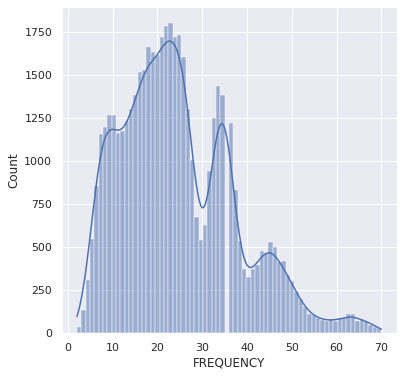

In [18]:
path_to_file = 'Acoustic_Extinguisher_Fire_Dataset.csv'
df = file_extension_read(path_to_file)
target = 'STATUS' #'STATUS', 'Exited'
sample_size = 50000
threshold_value = 90 
min_value = 0
max_value = 0
model_present = 'yes' #'yes', 'no'
model_path = 'best_classification_model.pkl'
model_obj = joblib.load(model_path)
#model_obj = 'temp'
problem_type = 'clf' #'reg'
less_great = 'Greater than' #'Less than'
project_name = 'Acoustic_Extinguisher_Fire_Dataset'

memory_usage, total_time = start_process(df, target, sample_size, threshold_value, min_value, max_value, model_present, model_obj, less_great, project_name)
print("memory_usage = ", memory_usage)
print("total_time = ", total_time)


R2 Score:  NA


For how many variables do you want to apply the constraint:  0



Model Used: GaussianCopula
Closeness to the real value dataset: 79.67%

Estimated Risk calculated by the simulation program: 91.98%
RAM Usage [Bytes]: 21846297
Total time taken [Seconds]: 37.585527420043945
df_histo value count Outside-Range    35843
In-Range         14157
Name: Category, dtype: int64
interval columns not set, guessing: ['House_Age', 'Nearest_Station', 'Convenience_Stores', 'Latitude', 'Longitude']
memory_usage =  21846297
total_time =  37.585527420043945


<Figure size 504x648 with 0 Axes>

<Figure size 936x936 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

<Figure size 432x432 with 0 Axes>

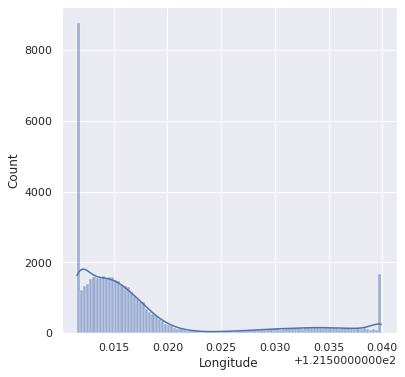

In [18]:
path_to_file = 'house_price.csv'
df = file_extension_read(path_to_file)
target = 'House_Price'
sample_size = 50000
threshold_value = 30
min_value = -5
max_value = 5
model_present = 'yes' #'yes', 'no'
model_path = 'best_regression_model.pkl'
model_obj = joblib.load(model_path)
#model_obj = 'temp'
problem_type = 'reg'
less_great = 'null'
project_name = 'House Price Prediction'

memory_usage, total_time = start_process(df, target, sample_size, threshold_value, min_value, max_value, model_present, model_obj, less_great, project_name)
print("memory_usage = ", memory_usage)
print("total_time = ", total_time)
